## Assignment 1: SIR model (ODE)

**Important:** This notebook needs to be run **in order**

The SIR model is an epidemiological model that computes the spread of an infectious disease through a population of people. It is used to compute the number of susceptible (S), infected (I), and recovered (R) individuals at any given time through the spread of an infectious disease. The model can be written as a set of first order differential equations:
$$
\begin{align*}
    \frac{\delta S}{\delta t} &= -\beta SI \\
    \frac{\delta I}{\delta t} &= \beta SI - \gamma I\\
    \frac{\delta R}{\delta t} &= \gamma I
\end{align*}
$$
Here $\beta$ is the parameter for the rate of infection and $\gamma$ is the parameter for the rate of recovery. A first assumption can be made keeping the population in our model "closed" meaning $S + I + R = 1$.

### Problem 1: Numerical integration of the basic model

In the basic model we can assume the population is fixed $S + I + R = 1$. The spread of infection goes one direction from susceptible to infected to recovered. Once an individual is recovered he or she is no longer susceptible.

#### 1.1 Numerical integration

Numerically integrate the above ODEs for states of an epidemic and no epidemic. What is the parameter that determines if the infectious disease will become an epidemic? Provide phase space diagrams, with analysis, of the system.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.optimize as scopt

plt.ion()
plt.rcParams['figure.figsize'] = 8, 6

First, we define the SIR model derivatives to be used for numerical integration

In [2]:
# ODE in the form dy/dt = f(y, t)
def sir(y, t, beta, gamma):
    """ basic SIR model """
    Si, Ii, Ri = tuple(y)
    dSdt = -beta*Si*Ii
    dIdt = beta*Si*Ii - gamma*Ii
    dRdt = gamma*Ii
    return np.array([dSdt, dIdt, dRdt])

We will also need a utility function to numerically integrate this and subsequent SIR models and plot the results. We paremterize this function so that we can use it throughout this assignment.

In [3]:
def plot_model(
    t,
    graphs,
    show = True, # show the generated plot
    title = None, # title of the plot
    save_as = None, # filename of the plot
):
    fig, ax = plt.subplots()
    for D, options in graphs:
        ax.plot(t, D, **options)
    days = int(np.ceil(t[-1]-t[0]))
    if days > 365:
        plt.xlabel('year')
        year_step = 365
        if days > 10 * 365:
            year_step = 10 * 365
        years = np.arange(
            0,
            np.ceil(days/year_step)*year_step + year_step,
            year_step
        )
        plt.xticks(
            years,
            (years/365).astype(int)
        )
    else:
        plt.xlabel('day')
    plt.ylabel('fraction of population')
    plt.title(title)
    plt.legend(loc=0)
    plt.tight_layout()
    if save_as:
        parent_dir = os.path.dirname(save_as)
        os.makedirs(parent_dir, exist_ok=True)
        plt.savefig(save_as)
    if show:
        plt.show()
    return fig, ax

def model_sir_infections(
    model, # model to use
    y0, # initial condition vector
    *parameters, # model parameters
    days = 90, # number of years to compute
    resolution = 1000, # resolution of numerical integration
    closed = True, # assume closed (constant) population
    plot_s = False, # plot susceptible
    plot_i = False, # plot infected
    plot_r = False, # plot recovered
    show = True, # show the generated plot
    title = None, # title of the plot
    save_as = None, # filename of the plot
):
    assert len(parameters) >= 2 # need at least beta, gamma
    t = np.linspace(0, days, days * resolution)
    sol = scint.odeint(model, y0, t, args=parameters)
    S = sol[:, 0]
    I = sol[:, 1]
    R = sol[:, 2]
    if closed:
        assert np.allclose(sol.sum(axis=1), 1.)
    
    # plot
    if any([plot_s, plot_i, plot_r]):
        graphs = []
        if plot_s:
            graphs.append((S, dict(label='Susceptible')))
        if plot_i:
            graphs.append((I, dict(label='Infected')))
        if plot_r:
            graphs.append((R, dict(label='Recovered')))
        plot_model(
            t, graphs,
            show=show,
            title=title,
            save_as=save_as,
        )
    return S, I, R, t

Now, we are ready to plot phase space diagrams for epidemic and non-epidemic states of an infectious disease.

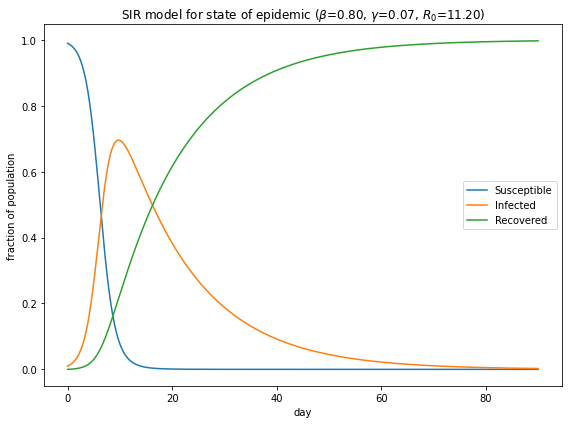

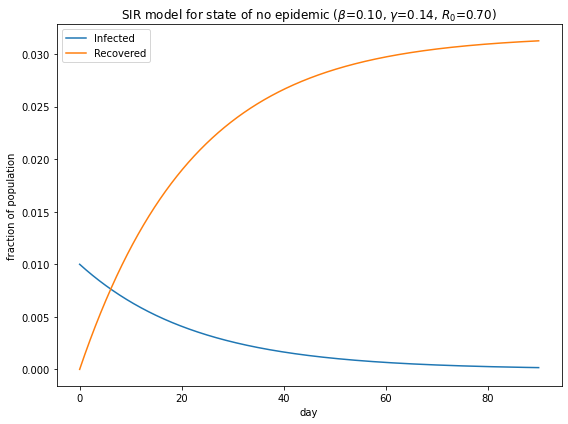

In [4]:
# initial conditions
I0 = 0.01 # initial number of infected people
S0 = 1.0 - I0 # initial number of susceptible people
R0 = 0.0 # initial number of recovered people
y0 = np.array([S0, I0, R0]) # initial condition vector
assert np.sum(y0) == 1.0

for state, parameters in {
    "epidemic": dict(beta=0.8, gamma=1/14, plot_s=True),
    "no epidemic": dict(beta=0.1, gamma=1/7, plot_s=False),
}.items():
    beta = parameters["beta"]
    gamma = parameters["gamma"]
    R0 = beta / gamma
    title = (
        "SIR model for state of "
        "%s ($\\beta$=%.2f, $\gamma$=%.2f, $R_0$=%.2f)" % (
            state, beta, gamma, R0
        ))
    S, I, R, t = model_sir_infections(
        sir,
        y0, beta, gamma,
        days=90, resolution=1_00, closed=True,
        plot_s=parameters["plot_s"],
        plot_i=True,
        plot_r=True,
        title = title,
        save_as = "./fig/a1/ex1.1_%s.pdf" % state.replace(" ", "_"),
    )

#### 1.2 Fitting SIR

Given below is the historical data from a case of an influenza outbreak situation. The outbreak was in a boys school with a total of 763 boys. It also seems that one infected boy started the epidemic. Could you try to fit an SIR model to the data?

In [5]:
N_pop = 763.0 # total population size

# historical data for 15 days
# we add the first day with just one infected boy
historical_data = np.array([
    1, 3,8,28,75,221,291,255,235,190,125,70,28,12,5
])

In [6]:
I0 = 1.0/N_pop # initial number of infected people
S0 = 1.0 - I0 # initial number of susceptible people
R0 = 0.0 # initial number of recovered people
y0 = np.array([S0, I0, R0]) # initial condition vector

days = len(historical_data)
t = np.linspace(0, days, days)

First, use bounded differential evolution to find a good guess for $\beta$ and $\gamma$.

In [7]:
def number_infected_boys(t, beta, gamma):
    sol = scint.odeint(sir, y0, t, args=(beta, gamma))
    infected = sol[:,1] * N_pop
    return infected

def mse_error(params):
    beta, gamma = params
    delta = historical_data - number_infected_boys(t, beta, gamma)
    return np.sum(np.square(delta))

bounds = [[0,2], [0,2]]
guess = scopt.differential_evolution(mse_error, bounds, seed=3)
beta, gamma = guess.x
print("fitted: beta=%.2f gamma=%.2f (MSE=%.2f)" % (
    beta, gamma, mse_error((beta, gamma))
))

fitted: beta=1.55 gamma=0.42 (MSE=4092.00)


Give it another try using least squares and choosing the previous parameters as the initial guess

In [8]:
fitted, _ = scopt.curve_fit(number_infected_boys, t, historical_data, p0=(beta, gamma))
beta, gamma = fitted
print("fitted: beta=%.2f gamma=%.2f (MSE=%.2f)" % (
    beta, gamma, mse_error((beta, gamma))
))

fitted: beta=1.55 gamma=0.42 (MSE=4092.00)


We can see that the parameters did not change, so we will continue to plot them

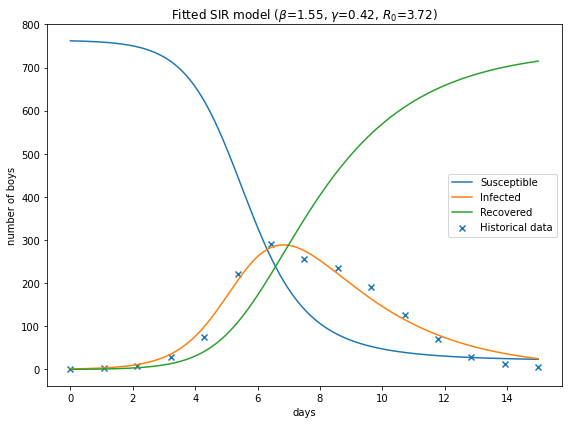

In [9]:
S, I, R, t = model_sir_infections(
    sir,
    y0, beta, gamma,
    days=days, resolution=1_00, closed=True
)
R0 = beta / gamma
title = (
    "Fitted SIR model "
    "($\\beta$=%.2f, $\gamma$=%.2f, $R_0$=%.2f)" % (
        beta, gamma, R0
    ))

fig, ax = plot_model(
    t, [
        (S*N_pop, dict(label='Susceptible')),
        (I*N_pop, dict(label='Infected')),
        (R*N_pop, dict(label='Recovered')),
    ],
    show=False,
)
# additionally plot the historical data
ax.scatter(
    np.linspace(0, days, days), historical_data,
    label='Historical data', marker="x"
)
plt.xlabel('days')
plt.ylabel('number of boys')
plt.title(title)
plt.legend(loc=0)
plt.tight_layout()
plt.savefig("./fig/a1/ex1.2_fitted.pdf")
plt.show()

#### 1.3 Vaccination Plan

Can you propose a vaccination plan to prevent the epidemic?

To model the effect that constant long-term vaccination of a fraction $p$ of newborns
against an infection with a basic reproductive ratio $R_0$ has, we replace the transmission rate $\beta$ with $\beta(1-p)$.

This yields the following SIR model equations with vaccination:
$$
\begin{align*}
    \frac{\delta S}{\delta t} &= -\beta(1-p) SI + \mu - \mu S \\
    \frac{\delta I}{\delta t} &= \beta(1-p) SI - \gamma I - \mu I\\
    \frac{\delta R}{\delta t} &= \gamma I - \mu R
\end{align*}
$$

Note that when dealing with the vaccination of newborns it makes sense to add a birth (and death) rate $\mu$ to the model, which will be discussed in more detail in the second problem and can be ignored for now.

In [10]:
# ODE in the form dy/dt = f(y, t)
def sir_vaccination(y, t, beta, gamma, birth, death, p):
    """ basic SIR model with vaccination """
    Si, Ii, Ri = tuple(y)
    assert birth == death
    dSdt = -beta*(1-p)*Si*Ii + birth - death*Si
    dIdt = beta*(1-p)*Si*Ii - gamma*Ii - death*Ii
    dRdt = gamma*Ii - death*Ri
    return np.array([dSdt, dIdt, dRdt])

critical prop. of newborns needed to be vaccinated p_c=0.73


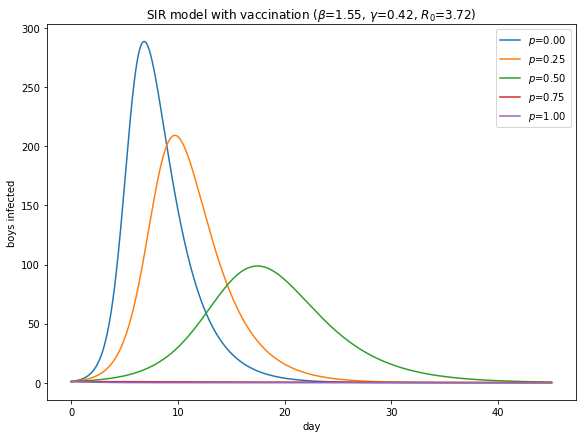

In [11]:
p_c = 1-(1/R0)
print((
    "critical prop. of newborns needed to be vaccinated "
    "p_c=%.2f" % p_c
))

fig, ax = plt.subplots()
title = (
    "SIR model with vaccination "
    "($\\beta$=%.2f, $\gamma$=%.2f, $R_0$=%.2f)" % (
        beta, gamma, R0
    ))
death = 1/(80.0*365.0) # assume life expectency of 80 years 
birth = death
for p in np.linspace(0, 1.0, 5):
    S, I, R, t = model_sir_infections(
        sir_vaccination,
        y0, beta, gamma, birth, death, p,
        days=45, resolution=1_00, closed=True
    )
    ax.plot(t, N_pop*I, label='$p$=%.2f' % p)
plt.title(title)
plt.legend(loc=0)
plt.tight_layout()
plt.xlabel('day')
plt.ylabel('boys infected')
plt.savefig( "./fig/a1/ex1.3_vaccination.pdf")
plt.show()

### Problem 2: Demography

Now we want to start to add more terms to our model. Lets start to consider demography, i.e. Birth and death rates.

#### 2.1 Demographic SIR model

Add birth and natural death rate term into model. (Hint: keep $N_{population}$ constant). How does the dynamics change? Run the model to capture an endemic state. Do you see oscillatory behavior in the fraction of infected population? What are requirements to observe this behavior? What is the frequency and amplitude of these oscillations (Hint: use Fourier analysis)?

We will incorporate the parameter $\mu$ as the natural birth and death rate into the model. In the code, we distinguish between the birth and death rate for the sake of readability, but always keep them equal $\mu = \verb|death| = \verb|birth|$.

Adding a constant natural birth and death rate $\mu$, we get the following set of ordinary differential equations (ODEs) for the SIR model:
$$
\begin{align*}
    \frac{\delta S}{\delta t} &= -\beta SI + \mu - \mu S \\
    \frac{\delta I}{\delta t} &= \beta SI - \gamma I - \mu I\\
    \frac{\delta R}{\delta t} &= \gamma I - \mu R
\end{align*}
$$

In [12]:
# ODE in the form dy/dt = f(y, t)
def sir_demography(y, t, beta, gamma, birth, death):
    """ demographic SIR model with natural birth and death rate """
    Si, Ii, Ri = tuple(y)
    assert birth == death
    dSdt = -beta*Si*Ii + birth - death*Si
    dIdt = beta*Si*Ii - gamma*Ii - death*Ii
    dRdt = gamma*Ii - death*Ri
    return np.array([dSdt, dIdt, dRdt])

Now, we give one sample configuration of an endemic state where we can clearly see the expected oscillatory behaviour.

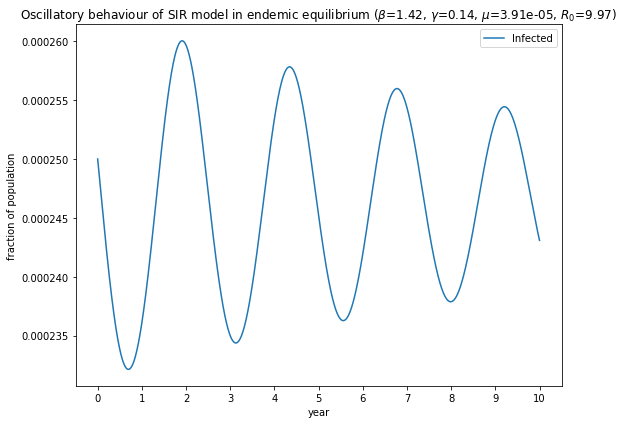

In [13]:
# initial conditions
I0 = 2.5*1e-4  # initial number of infected people
S0 = 0.1 # initial number of susceptible people
R0 = 1.0 - (I0 + S0) # initial number of recovered people
y0 = np.array([S0, I0, R0]) # initial condition vector

beta  = 520.0/365.0
gamma = 1.0/(7.0)
death = 1.0/(70.0*365.0)
birth = death
R0 = beta / (gamma + death)
title = (
    "Oscillatory behaviour of SIR model in endemic equilibrium "
    "($\\beta$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $R_0$=%.2f)" % (
        beta, gamma, death, R0
    ))

S, I, R, t = model_sir_infections(
    sir_demography,
    y0, beta, gamma, death, birth,
    days=10 * 365, resolution=1_00, closed=True,
    plot_i=True, title=title,
    save_as="./fig/a1/ex2.1_oscillation_harmonic.pdf"
)

The oscillatory behaviour can always be observed for the endemic equilibrium, where the mean number of infected people of the population converges to some equilibrium $I>0$. The requirement for an endemic equilibrium is that $R_0>1$. Recall that $R_0$ determines the number of secondary infections per index case in a naive population of susceptible individuals and is defined as
$$
R_0 = \frac{\beta}{\gamma + \mu}
$$
assuming that the entire population is susceptible ($S=1 - I$).

Furthermore, the period of oscillation $T$ is then given by
$$
T \sim 2\pi\sqrt{AG}
$$
with $A=\frac{1}{\mu(R_0 - 1)}$ denoting the mean age of infection and $G=\frac{1}{\mu + \gamma}$ denoting the typical period of a host's infectivity.

We can also show that we cannot see oscillatory behaviour for the state of the disease-free equilibrium ($R_0<1$) 

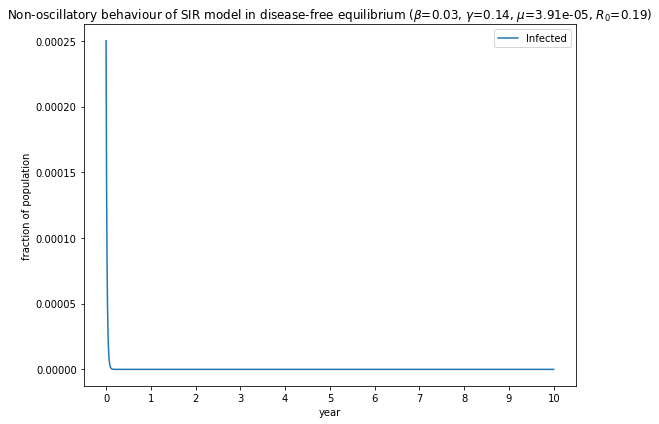

In [14]:
beta  = 10.0/365.0 # reduce the infection rate significantly
gamma = 1.0/(7.0) # same as before
death = 1.0/(70.0*365.0) # same as before
birth = death
R0 = beta / (gamma + death)
title = (
    "Non-oscillatory behaviour of SIR model in disease-free equilibrium "
    "($\\beta$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $R_0$=%.2f)" % (
        beta, gamma, death, R0
    ))

S, I, R, t = model_sir_infections(
    sir_demography,
    y0, beta, gamma, death, birth,
    days=10 * 365, resolution=1_00, closed=True
)
start = 0 * 365
fig, ax = plot_model(
    t[start:], [
        (I[start:], dict(label='Infected')),
    ],
    title=title,
    save_as="./fig/a1/ex2.1_no_oscillation.pdf"
)

However, it must be noted that not all oscillations in the state of endemic equilibrium are perfectly harmonic, as the number of infected people can not be negative. The following example illustrates that

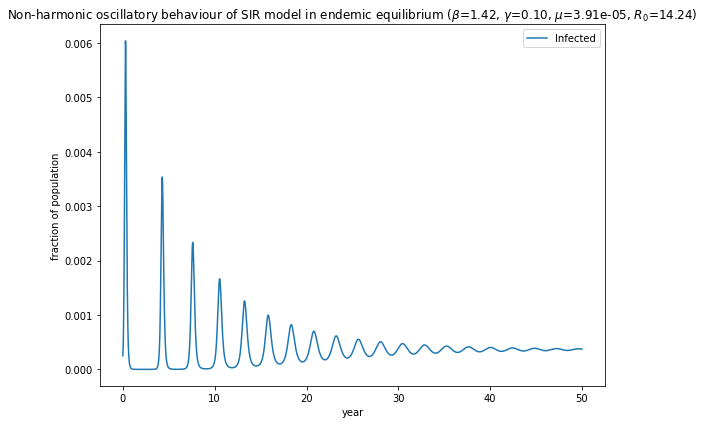

In [15]:
beta  = 520.0/365.0 # same as before
gamma = 1.0/(10.0) # longer infection period (7 to 14 days)
death = 1.0/(70.0*365.0) # same as before
birth = death
R0 = beta / (gamma + death)
title = (
    "Non-harmonic oscillatory behaviour of SIR model in endemic equilibrium "
    "($\\beta$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $R_0$=%.2f)" % (
        beta, gamma, death, R0
    ))

S, I, R, t = model_sir_infections(
    sir_demography,
    y0, beta, gamma, death, birth,
    days=50 * 365, resolution=1_00, closed=True,
    plot_i=True, title=title,
    save_as="./fig/a1/ex2.1_oscillation_non_harmonic.pdf"
)

Now, we want to find the frequencies and amplitudes of the oscillation in the previous plot using Fourier analysis and compare it to the expected values for $T$.

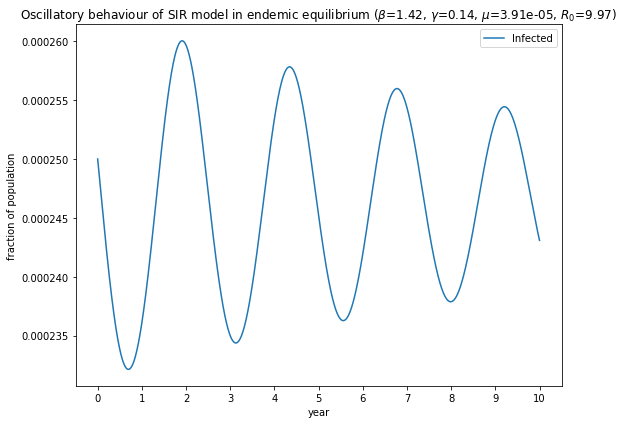

expected frequency f=0.00113 (T=887.10)
dominant frequency f=0.00110 (T=912.50)
max. amplitude of the dominant frequency phi_f=1.93290


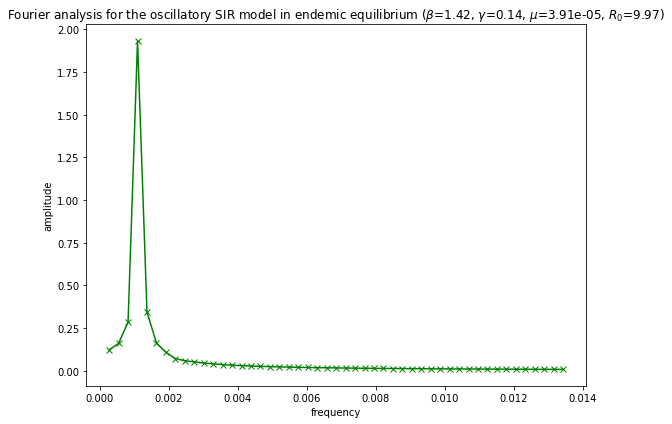

In [16]:
import scipy.fft

# use parameters for oscillatory behaviour again
beta  = 520.0/365.0
gamma = 1.0/(7.0)
death = 1.0/(70.0*365.0)
birth = death
R0 = beta / (gamma + death)
title = (
    "Oscillatory behaviour of SIR model in endemic equilibrium "
    "($\\beta$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $R_0$=%.2f)" % (
        beta, gamma, death, R0
    ))
S, I, R, t = model_sir_infections(
    sir_demography,
    y0, beta, gamma, death, birth,
    days=10 * 365, resolution=1_00, closed=True,
    plot_i=True, title=title
)

fourier = scipy.fft.rfft(I)
freqs = scipy.fft.rfftfreq(len(I), d=t[1]-t[0])
assert freqs.shape == fourier.shape

# compute the expected theoretical period T
A = 1.0/(death*(R0 - 1.0)) # mean age at infection
G = 1.0/(death + gamma) # period of host infectivity
T = 2*np.pi*np.sqrt(A*G)
print("expected frequency f=%.5f (T=%.2f)" % (1/T, T))

amps = np.abs(fourier)
dominant_freq_idx = np.argmax(amps[1:])
dominant_freq = freqs[1:][dominant_freq_idx]
dominant_amp = amps[1:][dominant_freq_idx]
print("dominant frequency f=%.5f (T=%.2f)" % (dominant_freq, 1/dominant_freq))
print("max. amplitude of the dominant frequency phi_f=%.5f" % dominant_amp)

title = "Fourier analysis for the oscillatory SIR model in endemic equilibrium ($\\beta$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $R_0$=%.2f)" % (
    beta, gamma, death, R0
)

fig, ax = plt.subplots()
i_min = 1
i_max = 50
ax.plot(freqs[i_min:i_max], amps[i_min:i_max], marker="x", c='green')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title(title)
plt.tight_layout()
plt.savefig("./fig/a1/ex2.1_fourier_analysis.pdf")
plt.show()

#### 2.2 Infection induced mortality

Add an infection induced mortality term to the model ($N_{population} \neq$ constant), which will depend on some probability of dying while infected. What happens when the probability approaches 1?

We introduce $\rho$ as probability of dying from the infection, which gives a new total rate of death
$$
m = \frac{\rho}{1-\rho}(\gamma + \mu)
$$
With rate $m$, the updated equation for $\frac{\delta I}{\delta t}$ are described by
$$
\begin{align*}
    \frac{\delta I}{\delta t} &= \beta SI - (\gamma + \mu)I - \frac{\rho}{1-\rho}(\gamma + \mu)I
\end{align*}
$$

In [17]:
def sir_demography_mortality(y, t, beta, gamma, birth, death, mortality):
    """ demographic SIR model with infection induced mortality """
    Si, Ii, Ri = tuple(y)
    assert birth == death
    assert mortality < 1.0 # avoid division by zero
    dSdt = -beta*Si*Ii + birth - death*Si
    dIdt = beta*Si*Ii - gamma*Ii - death*Ii - mortality/(1.0 - mortality)*(death + gamma)*Ii
    dRdt = gamma*Ii - death*Ri
    return np.array([dSdt, dIdt, dRdt])

We now investigate empirically what happens when the probability of dying of infection $\rho$ approaches 1.

Analytically, one can already see that 
$$
\lim_{\rho\to1} \frac{\rho}{1-\rho}(\gamma + \mu)I = \infty
$$
for $\gamma + \mu > 0$ and $I> 0$, hence the number of infections will rapidly decrease as $\rho\to1$.

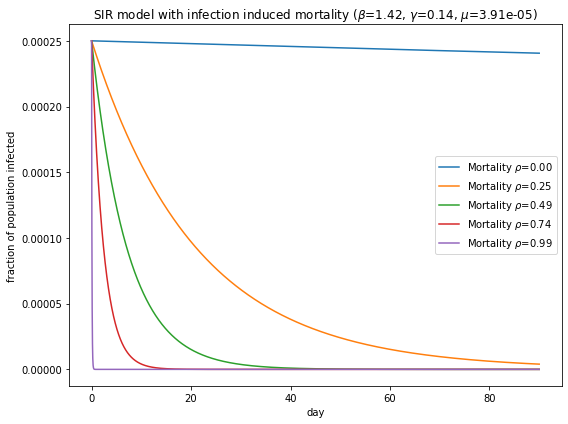

In [18]:
fig, ax = plt.subplots()
plt.xlabel('day')
plt.ylabel('fraction of population infected')
title = (
    "SIR model with infection induced mortality "
    "($\\beta$=%.2f, $\gamma$=%.2f, $\mu$=%.2e)" % (
        beta, gamma, death
    ))
for mortality in np.linspace(0, 0.99, 5):
    S, I, R, t = model_sir_infections(
        sir_demography_mortality,
        y0, beta, gamma, death, death, mortality,
        days=90, resolution=1_00, closed=False
    )
    ax.plot(t, I, label='Mortality $\\rho$=%.2f' % mortality)
plt.title(title)
plt.legend(loc=0)
plt.tight_layout()
plt.savefig("./fig/a1/ex2.2_infection_induced_mortality.pdf")
plt.show()

## Problem 3: Variation on the SIR model

Pick a variation of the SIR model and provide similar detail and analysis used in the
previous problems. Some examples can be SIER, MSIR, SEIS, MSEIR, MSEIRS etc.
Add seasonal effects into the model you choose (Hint: add a time varying sinusoidal rate
of infection).

In the following, we will analyse the SEIR (SIER) model of infection, which takes into account the latent period of exposed (E) individuals which are 
infected but not yet infectious.

Introducing the rate of exposure $\sigma$ corresponding to the average duration of the latent period $\frac{1}{\sigma}$, the SEIR model is described by the following set of coupled ordinary differential equations (ODE's):
$$
\begin{align*}
    \frac{\delta S}{\delta t} &= -\beta SI + \mu - \mu S \\
    \frac{\delta E}{\delta t} &= \beta SI - \sigma E - \mu E\\
    \frac{\delta I}{\delta t} &= \sigma E - \gamma I - \mu I\\
    \frac{\delta R}{\delta t} &= \gamma I - \mu R
\end{align*}
$$
Note that except for $\sigma$, the parameters are the same as for the SIR model with demographics (natural birth and death rates). Note that $\frac{\delta I}{\delta t}$ had to be changed to account for the group of exposed population E.

Having established the SEIR model, we wish to extend the model to take seasonal effects into account. Such models are called _temporally forced_.
This makes a lot of practical sense, because it is commonly known that transmission rates increase during autumn and winter when people are closer to each other in poorly ventilated rooms. The same applies to childhood
infections which are peaking at the start of the school year and declining in the summer.
Moreover, we could imagine this to potentially also be useful to model infectious diseases for which the pathogen units (e.g. bacterial cells or virions) are highly sensitive to differences in temperature and might not withstand cold or heat.

Having established the usefulness of a time varying rate of infection $\beta$, we model $\beta$ as a function of time $t$:
$$
\beta(t) = \beta_0(1 + \beta_1\cos(\omega t))
$$
Here, the parameter $\beta_0$ denotes the baseline transmission rate, $\omega$ denotes the period of the seasonal forcing, and $\beta_1$ denotes the amplitude of the seasonality ($0\leq \beta_1 \leq 1$).

In [19]:
# ODE in the form dy/dt = f(y, t)
def seir_seasonal(y, t, beta0, beta1, omega, gamma, birth, death, latent):
    """ demographic SIR model with natural birth and death rate """
    Si, Ei, Ii, Ri = tuple(y)
    assert birth == death
    beta = beta0*(1 + beta1*np.cos(omega*t))
    dSdt = -beta*Si*Ii + birth - death*Si
    dEdt = beta*Si*Ii - latent*Ei - death*Ei
    dIdt = latent*Ei - gamma*Ii - death*Ii
    dRdt = gamma*Ii - death*Ri
    return np.array([dSdt, dEdt, dIdt, dRdt])

In [20]:
def model_seir_infections(
    model, # model to use
    y0, # initial condition vector
    *parameters, # model parameters
    days = 90, # number of years to compute
    resolution = 1000, # resolution of numerical integration
    closed = True, # assume closed (constant) population
    plot_s = False, # plot susceptible
    plot_e = False, # plot exposed
    plot_i = False, # plot infected
    plot_r = False, # plot recovered
    show = True, # show the generated plot
    title = None, # title of the plot
    save_as = None, # filename of the plot
):
    assert len(parameters) >= 2 # need at least beta, gamma
    t = np.linspace(0, days, days * resolution)
    sol = scint.odeint(model, y0, t, args=parameters)
    S = sol[:, 0]
    E = sol[:, 1]
    I = sol[:, 2]
    R = sol[:, 3]
    if closed:
        assert np.allclose(sol.sum(axis=1), 1.)
    
    # plot
    if any([plot_s, plot_e, plot_i, plot_r]):
        graphs = []
        if plot_s:
            graphs.append((S, dict(label='Susceptible')))
        if plot_e:
            graphs.append((E, dict(label='Exposed')))
        if plot_i:
            graphs.append((I, dict(label='Infected')))
        if plot_r:
            graphs.append((R, dict(label='Recovered')))
        plot_model(
            t, graphs,
            show=show,
            title=title,
            save_as=save_as,
        )
    return S, E, I, R, t

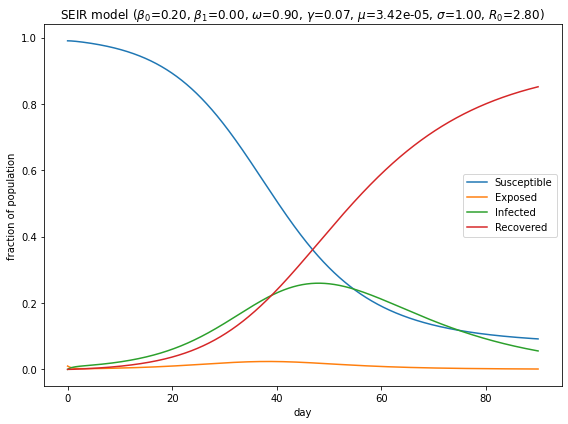

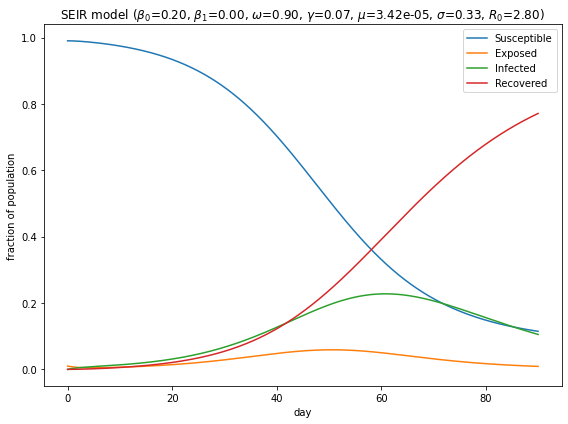

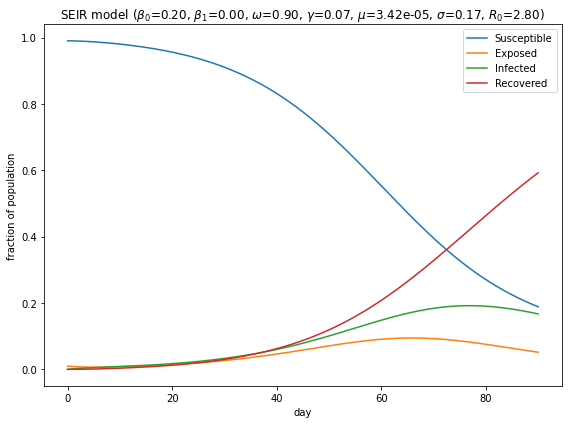

In [21]:
# initial conditions
E0 = 0.01 # initial number of exposed people
I0 = 0.0 # initial number of infected people
S0 = 1.0 - (I0 + E0) # initial number of susceptible people
R0 = 0.0 # initial number of recovered people
y0 = np.array([S0, E0, I0, R0]) # initial condition vector
assert np.sum(y0) == 1.0

beta0 = 0.2 # infection rate
beta1 = 0.0 # no seasonal amplitude for now
omega = 2*np.pi/7.0 # seasonal period

gamma=1/14 # 14 days of until recovery
latent = 1/3 # 3 days of latent period

death = 1/(80.0*365) # life expectency of 80 years
birth = death
days = 90

for state, parameters in {
    "latent_normal": dict(latent=1/1), # 1 days of latent period
    "latent_mild": dict(latent=1/3), # 3 days of latent period
    "latent_strong": dict(latent=1/6), # 6 days of latent period
}.items():
    latent = parameters["latent"]
    R0 = beta0 / gamma
    title = (
        "SEIR model "
        "($\\beta_0$=%.2f, $\\beta_1$=%.2f, $\omega$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $\sigma$=%.2f, $R_0$=%.2f)" % (
            beta0, beta1, omega, gamma, birth, latent, R0
        ))
    S, E, I, R, t = model_seir_infections(
        seir_seasonal,
        y0, beta0, beta1, omega, gamma, birth, death, latent,
        days=days, resolution=1_00, closed=True,
        plot_s=True,
        plot_e=True,
        plot_i=True,
        plot_r=True,
        title = title,
        save_as = "./fig/a1/ex3.1_%s.pdf" % state.replace(" ", "_"),
    )

No handles with labels found to put in legend.


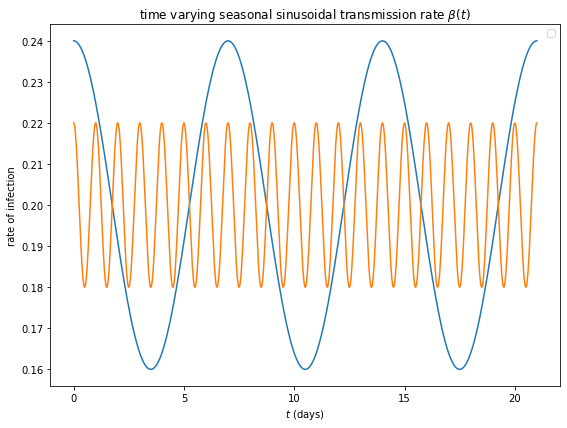

In [22]:
days = 3*7
t = np.linspace(0, days, days * 1_000)
fig, ax = plot_model(
    t, [],
    show=False,
    title="time varying seasonal sinusoidal transmission rate $\\beta(t)$",
)
for beta1, omega in [
    (0.2, 2*np.pi/7.0), # peak every monday
    (0.1, 2*np.pi/1.0), # daily
]:
    seasonal = beta0*(1 + beta1*np.cos(omega*t))
    ax.plot(t, seasonal, label="test")
plt.ylabel("rate of infection")
plt.xlabel("$t$ (days)")
plt.savefig("./fig/a1/ex3.1_sinusoidal.pdf")
plt.show()

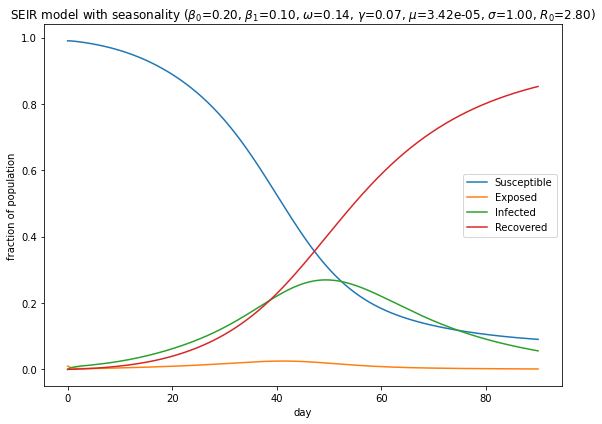

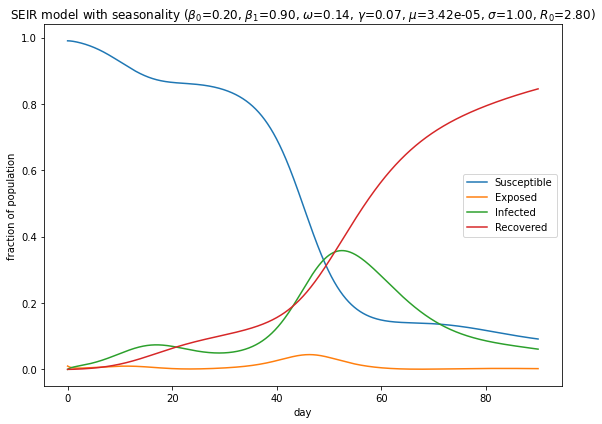

In [23]:
beta0 = 0.2 # infection rate
beta1 = 0.0 # no seasonal amplitude for now
omega = 2*np.pi/7.0 # seasonal period

gamma=1/14 # 14 days of until recovery
latent = 1/1 # 3 days of latent period

death = 1/(80.0*365) # life expectency of 80 years
birth = death
days = 90

for state, parameters in {
    "seasonal_weekly_mild": dict(beta1=0.1, omega=1/7),
    "seasonal_weekly_strong": dict(beta1=0.9, omega=1/7),
}.items():
    beta1 = parameters["beta1"]
    omega = parameters["omega"]
    R0 = beta0 / gamma
    title = (
        "SEIR model with seasonality "
        "($\\beta_0$=%.2f, $\\beta_1$=%.2f, $\omega$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $\sigma$=%.2f, $R_0$=%.2f)" % (
            beta0, beta1, omega, gamma, birth, latent, R0
        ))
    S, E, I, R, t = model_seir_infections(
        seir_seasonal,
        y0, beta0, beta1, omega, gamma, birth, death, latent,
        days=days, resolution=1_00, closed=True,
        plot_s=True,
        plot_e=True,
        plot_i=True,
        plot_r=True,
        title = title,
        save_as = "./fig/a1/ex3.1_%s.pdf" % state.replace(" ", "_"),
    )

0


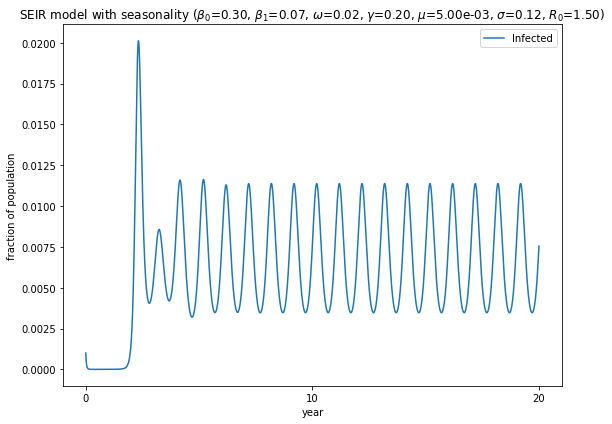

In [24]:
# initial conditions
E0 = 1e-3 # initial number of exposed people
I0 = 1e-3 # initial number of infected people
S0 = 6e-2 # initial number of susceptible people
R0 = 1.0 - (I0 + E0 + S0) # initial number of recovered people
y0 = np.array([S0, E0, I0, R0]) # initial condition vector
assert np.sum(y0) == 1.0

beta0 = 0.3 # baseline infection rate
beta1 = 0.075 # seasonal influence on the infection rate
omega = 2*np.pi/365 # annual seasonal period

gamma=1/(5/1) # 5 days of until recovery
latent = 1/(8/1) # 8 days of latent period

death = 0.005 # admittedly weird death rate
print(int((1/death)/365))
birth = death

years = 20

R0 = beta0 / gamma
title = (
    "SEIR model with seasonality "
    "($\\beta_0$=%.2f, $\\beta_1$=%.2f, $\omega$=%.2f, $\gamma$=%.2f, $\mu$=%.2e, $\sigma$=%.2f, $R_0$=%.2f)" % (
        beta0, beta1, omega, gamma, birth, latent, R0
    ))
S, E, I, R, t = model_seir_infections(
    seir_seasonal,
    y0, beta0, beta1, omega, gamma, birth, death, latent,
    days=years*365, resolution=1_000, closed=False,
    show=True,
    plot_i=True,
    title = title,
    save_as = "./fig/a1/ex3.1_recurrent_epidemics.pdf",
)